In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

# Seting up the environmet variables

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

# For now `ZIP_PATH` is set as a enviroment variable, In the end it will be a GET request to the server
_set_env("ZIP_PATH")

# Genrate the ASCII art of the file strucher by providing the file path as the parameter

In [3]:
from zipfile import ZipFile

def generate_tree_structure(zip_path):
    # Extract file names and build the file tree
    with ZipFile(zip_path, 'r') as zip_file:
        file_list = [f for f in zip_file.namelist() if not f.endswith('/')]
        
    def build_tree(file_paths):
        tree = {}
        for path in file_paths:
            parts = path.split('/')
            current = tree
            for part in parts:
                if part not in current:
                    current[part] = {}
                current = current[part]
        return tree
    
    def format_tree(tree, prefix=""):
        lines = []
        keys = list(tree.keys())
        for i, key in enumerate(keys):
            # Set prefix for the current node
            connector = "└── " if i == len(keys) - 1 else "├── "
            lines.append(f"{prefix}{connector}{key}")
            if isinstance(tree[key], dict):
                extension = "    " if i == len(keys) - 1 else "│   "
                lines.extend(format_tree(tree[key], prefix + extension))
        return lines
    
    tree = build_tree(file_list)
    tree_structure = format_tree(tree)
    return "\n".join(tree_structure)

# [Testing] Is ASCII art genarator working properly ?

In [4]:
zip_path = os.getenv('ZIP_PATH')
print(zip_path)
tree_structure = generate_tree_structure(zip_path)
print(tree_structure)

../artifacts/sample.zip
└── AdvancedTaskMangementSyastem-springboot-main
    ├── .gitignore
    ├── .mvn
    │   └── wrapper
    │       └── maven-wrapper.properties
    ├── mvnw
    ├── mvnw.cmd
    ├── pom.xml
    └── src
        ├── main
        │   ├── java
        │   │   └── com
        │   │       └── vipun
        │   │           └── task
        │   │               ├── TaskApplication.java
        │   │               ├── config
        │   │               │   ├── JwtAuthenticationFilter.java
        │   │               │   └── WebSecurityConfiguration.java
        │   │               ├── controller
        │   │               │   ├── admin
        │   │               │   │   └── AdminController.java
        │   │               │   ├── auth
        │   │               │   │   └── AuthController.java
        │   │               │   └── employee
        │   │               │       └── EmployeeController.java
        │   │               ├── dto
        │   │               │   ├── 

# Get the root directroy from the Zip Path

In [5]:
import os
import zipfile

def get_root_directory(zip_path: str) -> str:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get the list of all files in the ZIP archive
        file_list = zip_ref.namelist()
        
        # Find the common prefix (root directory)
        if not file_list:
            raise ValueError("The ZIP archive is empty.")
        
        # Sort the file list to ensure the root directory is at the beginning
        file_list.sort()
        
        # The root directory is the common prefix of all file paths
        root_dir = os.path.commonprefix(file_list)
        
        # Ensure the root directory ends with a separator
        if not root_dir.endswith('/'):
            root_dir = os.path.dirname(root_dir) + '/'
        
        return root_dir

# [Testing] Is `get_root_directory` function working propely ?

In [6]:
testing_root_directory = get_root_directory(zip_path=os.getenv("ZIP_PATH"))
print(testing_root_directory)

AdvancedTaskMangementSyastem-springboot-main/


# Tool to extract content from any Filename

In [7]:
import os
import zipfile
from typing import Optional, Type
from langchain_core.callbacks import AsyncCallbackManagerForToolRun, CallbackManagerForToolRun
from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field
import fnmatch

In [8]:
class ContentExtractorToolInput(BaseModel):
    file_name: str = Field(description="The name of the file to extract content from (e.g. 'pom.xml', 'Main.java', 'src/main/example/*.java')")

class ContentExtractorTool(BaseTool):
    name: str = "Content Extractor"
    description: str = "Extracts the content of a file from a ZIP archive."
    args_schema: Type[BaseModel] = ContentExtractorToolInput
    return_direct: bool = True

    def _run(self, file_name: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        zip_path = os.getenv('ZIP_PATH')


        print(file_name) # purpose: debug 

        if not zip_path:
            raise ValueError("ZIP_PATH environment variable is not set.")

        file_name = file_name.replace('file_name=', '').replace('"', '').replace("'", '')
        root_dir = get_root_directory(zip_path)

        full_file_path = root_dir + file_name

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Get the list of all files in the ZIP archive
            file_list = zip_ref.namelist()

            # Find all files that match the pattern
            matching_files = fnmatch.filter(file_list, full_file_path)

            if not matching_files:
                raise FileNotFoundError(f"No files matching {file_name} found in the ZIP archive.")

            # Extract the content of all matching files
            contents = []
            for file_path in matching_files:
                with zip_ref.open(file_path) as file:
                    contents.append(file.read().decode('utf-8'))

            return "\n".join(contents)

    async def _arun(self, file_name: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None) -> str:
        raise NotImplementedError("Async method not implemented for XMLContentExtractorTool.")

# [Testing] : Is the tool working properly ? 

In [9]:
# testing_tool = ContentExtractorTool()

# # testing_response = testing_tool.invoke('file_name="pom.xml"')
# # testing_response = testing_tool.invoke('file_name="src/main/java/com/vipun/task/TaskApplication.java"')
# testing_response = testing_tool.invoke('file_name=src/main/java/com/vipun/task/controller/*.java')

# print(testing_response)

# Setting up the Prompt Template

In [10]:
prompt = """
For the following task, make a detailed plan to review the code step-by-step by extracting 
content from each relevant file type in the project archive. For each step, specify the necessary 
file_name for the tool to retrieve content. Store the extracted content in a variable #E that can be 
referenced by later tools for analysis. (Plan, #E1, Plan, #E2, Plan, ...)

Tool to use:
(1) ContentExtractorTool[file_name]: Extracts content from any file in a ZIP archive. 
      Useful for retrieving the content of source code files, configuration files, or documentation. 
      The file_name can be a full relative path of the file (e.g., "src/Main.java" or "pom.xml") or a 
      pattern to match multiple files (e.g., "src/example/*.java"). When using a pattern, the tool 
      retrieves content from all matching files.

The plan should involve the following:
- For each file type, identify its purpose (e.g., Java source code for structure and logic, XML 
  for configuration, Markdown for documentation).
- Use the `ContentExtractorTool` with the correct file_name to extract the content.
- Assign the extracted content to a variable #E that will be referenced for analysis.
- Include detailed instructions for the analysis step to evaluate content using best practices, 
  structure, logic, documentation quality, or any other relevant criteria.

For example:
Task: Conduct a code review on the files within a Java project archive to analyze code structure, 
documentation quality, and best practices.

Plan: Extract the main Java file `Main.java` to review its structure, classes, and methods.
#E1 = ContentExtractorTool[file_name="src/Main.java"]

Plan: Analyze the content of `Main.java` for adherence to best practices, class design, and method usage.
#E2 = LLM[Review the Java code structure and best practices based on #E1]

Plan: Extract the main configuration file `pom.xml` to review project dependencies and configuration settings.
#E3 = ContentExtractorTool[file_name="pom.xml"]

Plan: Analyze the dependencies and plugins in `pom.xml` for adherence to configuration best practices.
#E4 = LLM[Evaluate configuration settings and dependencies in #E3]

Plan: Extract the Markdown file `README.md` to review the project documentation.
#E5 = ContentExtractorTool[file_name="README.md"]

Plan: Analyze the quality of the documentation in `README.md` for clarity, completeness, and professionalism.
#E6 = LLM[Review documentation quality based on #E5]

Begin!
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}
"""

In [11]:
import re

from langchain_core.prompts import ChatPromptTemplate

prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])

# [Vizlualize] Prompt template

In [12]:
task = f"Review the code in the given project directory. file structure: \n{tree_structure}"

In [13]:
print(prompt_template.format(task = task))

Human: 
For the following task, make a detailed plan to review the code step-by-step by extracting 
content from each relevant file type in the project archive. For each step, specify the necessary 
file_name for the tool to retrieve content. Store the extracted content in a variable #E that can be 
referenced by later tools for analysis. (Plan, #E1, Plan, #E2, Plan, ...)

Tool to use:
(1) ContentExtractorTool[file_name]: Extracts content from any file in a ZIP archive. 
      Useful for retrieving the content of source code files, configuration files, or documentation. 
      The file_name can be a full relative path of the file (e.g., "src/Main.java" or "pom.xml") or a 
      pattern to match multiple files (e.g., "src/example/*.java"). When using a pattern, the tool 
      retrieves content from all matching files.

The plan should involve the following:
- For each file type, identify its purpose (e.g., Java source code for structure and logic, XML 
  for configuration, Markdown for

# Create the Chat Instance of OpenAI 

In [14]:
from langchain_openai import ChatOpenAI

analyzing_llm = ChatOpenAI(
    model = "gpt-4o",
    api_key = os.getenv("OPENAI_API_KEY"),
    temperature=0,
)

In [15]:
planner_llm = ChatOpenAI(
    model ="gpt-4",
    api_key = os.getenv("OPENAI_API_KEY"),
    temperature=0,
)

# [Testing] Is that Completion working ?

In [16]:
# test_llm_response = analyzing_llm.invoke("What do you know about WSO2?")
# print(test_llm_response.content)

# Define the planner Node 

In [17]:
planner = prompt_template | planner_llm

# [Testing] Is planer working how we expect ?

In [18]:
# testing_planer_response = planner.invoke(prompt.format(task = task))

In [19]:
# print(testing_planer_response.content)

# Prepare the regex pattern for extract the Plan, Identifier, Tool and the Tool Input

# Gpt-4 Regex

In [20]:
import re

def extract_steps_info_4o_mini(text):
    # Define regex patterns
    plan_pattern = r'Plan: (.*)'
    e_pattern = r'^#E(\d+) = (\w+)\[(.*?)\]$'
    
    # Find all "Plan:" descriptions
    plans = re.findall(plan_pattern, text, flags=re.MULTILINE)
    
    # Find all "#E" entries
    e_entries = re.findall(e_pattern, text, flags=re.MULTILINE)
    
    # Pair each plan with its corresponding #E entry
    extracted_info = []
    for plan, e_entry in zip(plans, e_entries):
        e_number, tool_name, tool_input = e_entry
        extracted_info.append((plan.strip(), f"#E{e_number}", tool_name, tool_input.strip()))
    
    return extracted_info

In [21]:
# testing_extracted_info_4o_mini = extract_steps_info_4o_mini(testing_planer_response.content)

In [22]:
# print(testing_extracted_info_4o_mini)

# For the state managment defining the State

In [23]:
from typing import List
from typing_extensions import TypedDict


class State(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

# Define the `get_plan` give the instruction to the llm Step-by-Step

In [24]:
def get_plan(state: State):
    task = state["task"]
    result = planner.invoke({"task": task})
    print(result.content)
    matches = extract_steps_info_4o_mini(result.content)
    print(matches)
    return {"steps": matches, "plan_string": result.content}

# [Testing] Is get_planer function working properly ?

In [25]:
# plan = get_plan({"task": task})

In [26]:
# print(plan["steps"])

# print("======================================")
# print(plan["plan_string"])

# defining the helper funtion to get the current task

In [27]:
def _get_current_task(state: State):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1

# defining tool execution function

In [28]:
content_extractor_tool = ContentExtractorTool()

In [ ]:
def tool_execution(state: State ):
    """Worker node that executes the tools of a given plan."""
    # Retrieve the current step's details
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    
    # Initialize or retrieve previous results
    _results = state.get("results", {})

    # debug
    print(f"Step: {_step}, Step Name: {step_name}, Tool: {tool}, Tool Input: {tool_input}")
    
    # Replace placeholders in tool_input with actual values from _results
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v) if tool_input else tool_input
    
    # Execute the appropriate tool based on the tool name
    if tool == "ContentExtractorTool":
        result = content_extractor_tool.invoke({"file_name": tool_input})
    elif tool == "LLM":
        result = analyzing_llm.invoke(tool_input)
    else:
        raise ValueError(f"Unsupported tool: {tool}")
    
    # Update results with the current step's result
    _results[step_name] = str(result)
    return {"results": _results}

In [30]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""

In [31]:
def solve(state: State):
    plan = ""
    
    # Loop through each step to build the plan string
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = state.get("results", {})
        
        # Replace any placeholders in tool_input and step_name
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        
        # Append each step plan to the overall plan string with better formatting
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]\n\n"
    
    # Format the prompt with the completed plan and task
    prompt = solve_prompt.format(plan=plan.strip(), task=state["task"])
    
    # Invoke the LLM and get the result
    result = analyzing_llm.invoke(prompt)
    return {"result": result.content}

In [32]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [33]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(State)
graph.add_node(" ", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

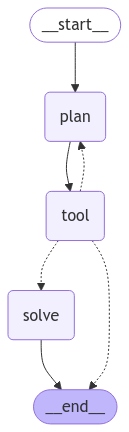

In [34]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [35]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

Plan: Extract the main Java file `TaskApplication.java` to review its structure, classes, and methods.
#E1 = ContentExtractorTool[file_name="src/main/java/com/vipun/task/TaskApplication.java"]

Plan: Analyze the content of `TaskApplication.java` for adherence to best practices, class design, and method usage.
#E2 = LLM[Review the Java code structure and best practices based on #E1]

Plan: Extract the Java files under the `config` directory to review the configuration settings and security measures.
#E3 = ContentExtractorTool[file_name="src/main/java/com/vipun/task/config/*.java"]

Plan: Analyze the configuration files for adherence to security best practices and proper configuration settings.
#E4 = LLM[Evaluate configuration settings and security measures in #E3]

Plan: Extract the Java files under the `controller` directory to review the API endpoints and their functionalities.
#E5 = ContentExtractorTool[file_name="src/main/java/com/vipun/task/controller/**/*.java"]

Plan: Analyze the

In [42]:
print(s["solve"]["result"])

The code in the given project directory is generally well-structured and follows good practices for a Spring Boot application. Here are the key points from the review:

1. **TaskApplication.java**: The main application file is correctly set up with the `@SpringBootApplication` annotation and a proper `main` method to launch the application.

2. **Configuration**: 
   - `JwtAuthenticationFilter` and `WebSecurityConfiguration` are well-implemented for JWT-based authentication, with appropriate security measures like stateless session management and role-based access control.

3. **Controllers**: 
   - The `AdminController`, `AuthController`, and `EmployeeController` follow RESTful conventions, but some improvements can be made, such as using appropriate HTTP methods and enhancing error handling.

4. **DTOs**: 
   - The DTOs are well-structured with Lombok annotations, but handling of sensitive data like passwords should be improved with exclusions from `toString()` and other methods.

5.